# Compute MOC along the approximate OSNAP array from ECCO

Here we compute volumetric transport along the OSNAP lines in depth space, which can be compared to recent observations. 

Here we show:

* how to get masks denoting the great circle arc between two points in space

* how to compute the transport or streamfunction across this section

* a comparison to observations

## Datasets to download

If you don't have any of the following datasets already, you will need to download them to complete the tutorial. Aside from the grid geometry file (which has no time dimension), you will need 2 monthly datasets for the full time span of ECCOv4r4 output (1992 through 2017). The ShortNames of the datasets are:

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**
- **ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4** (1992-2017)
- **ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4** (1992-2017)

If you haven't yet been through the [download tutorial](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html) or used the [ecco_download module](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html#ECCO_download-module), it may help you to review that information before downloading the datasets.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import cartopy as cart
import cartopy.crs as ccrs
notebook_path = os.getcwd()

In [3]:
# setting up a dask LocalCluster
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:49764/status,
Dashboard: http://127.0.0.1:49764/status,Workers: 4
Total threads: 16,Total memory: 31.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49765,Workers: 4
Dashboard: http://127.0.0.1:49764/status,Total threads: 16
Started: Just now,Total memory: 31.78 GiB
Comm: tcp://127.0.0.1:49807,Total threads: 4
Dashboard: http://127.0.0.1:49808/status,Memory: 7.94 GiB
Nanny: tcp://127.0.0.1:49770,


In [4]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [6]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

## Load ECCO variables
ecco_vars_adv_th = xr.open_mfdataset(join(ECCO_dir,'*_OCEAN_3D_TEMPERATURE_FLUX*MONTHLY*','*.nc'),\
                                      data_vars='minimal',coords='minimal',compat='override')
ecco_vars_uvw = xr.open_mfdataset(join(ECCO_dir,'*_OCEAN_3D_VOLUME_FLUX*MONTHLY*','*.nc'),\
                                      data_vars='minimal',coords='minimal',compat='override')

ecco_vars = xr.merge((ecco_vars_adv_th[['ADVx_TH','ADVy_TH']],ecco_vars_uvw[['UVELMASS','VVELMASS']]))

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ds = xr.merge((ecco_grid , ecco_vars))

### Load O-SNAP data

These data are available at https://www.o-snap.org/observations/data/ and are published in

Lozier, M. S., Li, F., Bacon, S., Bahr, F., Bower, A. S., Cunningham, S. A., … Zhao, J. (2019). A sea change in our view of overturning in the subpolar North Atlantic. Science, 363(6426), 516–521. https://doi.org/10.1126/science.aau6592

Download these files from the o-snap data page: https://www.o-snap.org/observations/data/

OSNAP_MOC_TimeSeries_201408_201805_2021.nc : https://smartech.gatech.edu/handle/1853/65537
OSNAP_MHT_MST_FW_TimeSeries_201408_201805_2020.nc : https://smartech.gatech.edu/handle/1853/63986

and put them in a path: 

In [7]:
# change this path as needed based on where you have stored the O-SNAP data files above
osnap_data_dir = join(user_home_dir,'Downloads','OSNAP')

In [8]:
obs1 = xr.open_dataset(join(osnap_data_dir,'OSNAP_MOC_TimeSeries_201408_201805_2021.nc'))
obs2 = xr.open_dataset(join(osnap_data_dir,'OSNAP_MHT_MST_FW_TimeSeries_201408_201805_2020.nc'))
obs = xr.merge((obs1,obs2))
print(obs)

<xarray.Dataset>
Dimensions:       (TIME: 47)
Coordinates:
  * TIME          (TIME) datetime64[ns] 2014-07-31 2014-08-30 ... 2018-05-11
Data variables: (12/24)
    MOC_ALL       (TIME) float64 ...
    MOC_ALL_ERR   (TIME) float64 ...
    MOC_WEST      (TIME) float64 ...
    MOC_WEST_ERR  (TIME) float64 ...
    MOC_EAST      (TIME) float64 ...
    MOC_EAST_ERR  (TIME) float64 ...
    ...            ...
    MHT_EAST      (TIME) float64 ...
    MHT_EAST_ERR  (TIME) float64 ...
    MST_EAST      (TIME) float64 ...
    MST_EAST_ERR  (TIME) float64 ...
    FW_EAST       (TIME) float64 ...
    FW_EAST_ERR   (TIME) float64 ...
Attributes: (12/17)
    title:                     OSNAP MOC time series (2014-2018)
    project:                   OSNAP
    contributor_name:          F. Li; M.S. Lozier; S. Bacon; A. Bower; S.A. C...
    contributor_role:          data design, collection and/or processing
    contributor_institution:   Georgia Institute of Technology, USA; National...
    publisher_na

## Define the OSNAP lines 

We define the OSNAP lines roughly by point pairs in `[longitude, latitude]` space. 
The lines are then computed via the function `ecco_v4_py.get_section_line_masks` as the great circle arc between these two points. 

See below for similar MATLAB functions

In [9]:
pt1_east = [-44, 60]
pt2_east = [-5, 56]

pt1_west = [-56, 51]
pt2_west = [-45, 60]

In [10]:
maskC_east, maskW_east, maskS_east = ecco.get_section_line_masks(pt1_east,pt2_east,ds)
maskC_west, maskW_west, maskS_west = ecco.get_section_line_masks(pt1_west,pt2_west,ds)
maskC_tot = (maskC_east+maskC_west).where(maskC_east+maskC_west==1,0)
maskW_tot = (maskW_east+maskW_west).where(np.abs(maskW_east)+np.abs(maskW_west)==1,0)
maskS_tot = (maskS_east+maskS_west).where(np.abs(maskS_east)+np.abs(maskS_west)==1,0)

-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


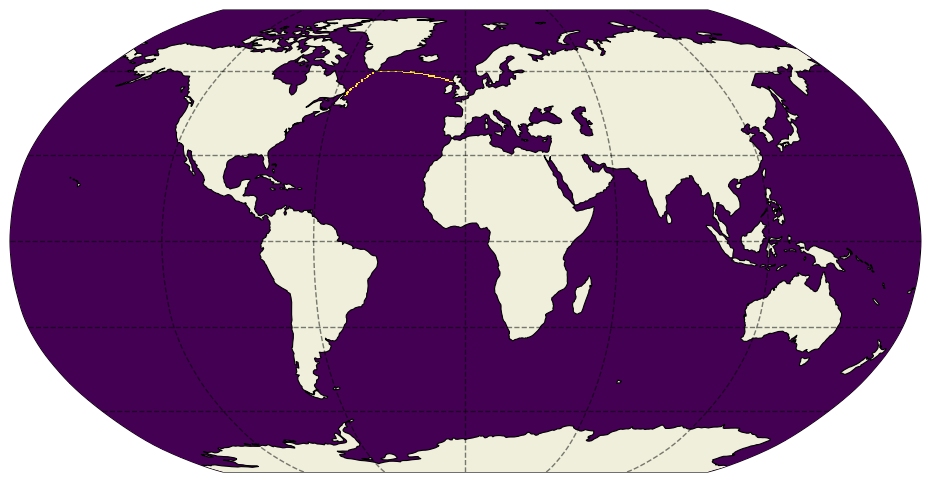

In [11]:
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,maskC_tot,cmap='viridis',projection_type='robin',user_lon_0=0);


-179.95 179.95000000000002
-180.0 180.0
-89.95 89.95
-90.0 90.0


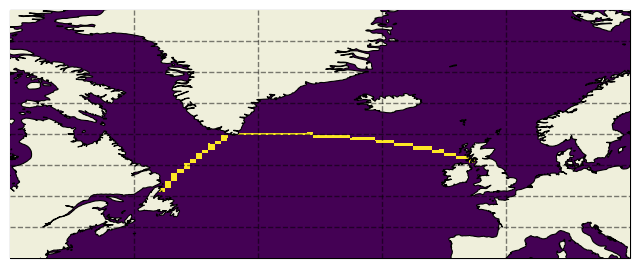

In [12]:
plt.figure(figsize=(8,8))
# use dx=.1, dy=.1 so that plot shows the osnap array as a thin 
# line.  remember, plot_proj_to_latlon_grid first interpolates
# the model grid to lat-lon with grid spacing as dx, dy
P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC, maskC_tot, \
                                cmap='viridis',\
                                projection_type='PlateCarree',\
                                lat_lim=45,dx=.1,dy=.1)
#ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
P[1].set_extent([-80, 20, 40, 80], crs=ccrs.PlateCarree())
plt.show()

We have defined many commonly used sections in oceanography so that users can access these easily. 
The available sections are shown below. 
This allows one to, e.g. compute volumetric transport across the Drake Passage as follows:

```
drake_vol = ecco_v4_py.calc_section_vol_trsp(ds,section_name='Drake Passage')
```

Similarly, we can do the same with `calc_section_heat_trsp` and `calc_section_salt_trsp`. 

One can also get these pre-defined section masks as follows:

```
pt1,pt2 = ecco_v4_py.get_section_endpoints('Drake Passage')
maskC, maskW, maskS = ecco_v4_py.get_section_line_masks(ds,pt1,pt2)
```

Finally, one can see similar functions in MATLAB:

* define general section masks: [gcmfaces_calc/gcmfaces_lines_transp.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/gcmfaces_lines_transp.m)

* see pre-defined section endpoints: [gcmfaces_calc/gcmfaces_lines_pairs.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/gcmfaces_lines_pairs.m)

In [13]:
ecco.get_available_sections()

['Bering Strait',
 'Gibraltar',
 'Florida Strait',
 'Florida Strait W1',
 'Florida Strait S1',
 'Florida Strait E1',
 'Florida Strait E2',
 'Florida Strait E3',
 'Florida Strait E4',
 'Davis Strait',
 'Denmark Strait',
 'Iceland Faroe',
 'Faroe Scotland',
 'Scotland Norway',
 'Fram Strait',
 'Barents Sea',
 'Labrador Greenland',
 'Hudson Strait',
 'English Channel',
 'Newfoundland Iberia',
 'Drake Passage',
 'Indonesia W1',
 'Indonesia W2',
 'Indonesia W3',
 'Indonesia W4',
 'Australia Antarctica',
 'Madagascar Channel',
 'Madagascar Antarctica',
 'South Africa Antarctica']

## Compute the overturning streamfunction in depth space

The function `calc_section_stf` computes the overturning streamfunction across the plane normal to the section denoted by the west and south masks. 
It is also possible to compute the overturning streamfunction at a particular latitude band, as is done to compare to the RAPID array, for instance. 
Please see the function `calc_meridional_stf` to do this, which is also in 
[ecco_v4_py.calc_stf](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_stf.py).

Note that we can also compute the volumetric, heat, or salt transport across these sections using the first three functions defined in [ecco_v4_py.calc_section_trsp](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_section_trsp.py).

In MATLAB, we can compute meridional overturning streamfunctions with [gcmfaces_calc/calc_overturn.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/calc_overturn.m).
Section transports can be computed with [gcmfaces_calc/calc_transports.m](https://github.com/gaelforget/gcmfaces/blob/readthedocs/gcmfaces_calc/calc_transports.m) once the masks are defined.

In [14]:
%%time
osnap_z_stf_east = ecco.calc_section_stf(ds,\
                                         pt1=pt1_east, \
                                         pt2=pt2_east,\
                                         section_name='OSNAP East Overturning Streamfunction').compute()

osnap_z_stf_west = ecco.calc_section_stf(ds, \
                                         pt1=pt1_west, \
                                         pt2=pt2_west,\
                                         section_name='OSNAP West Overturning Streamfunction').compute()

osnap_z_stf_tot = ecco.calc_section_stf(ds,\
                                        maskW=maskW_tot, \
                                        maskS=maskS_tot,\
                                        section_name='OSNAP Total Overturning Streamfunction').compute()

Wall time: 2min 51s


In [15]:
def osnap_depth_stf_vs_time(stf_ds,label):
    fig = plt.figure(figsize=(18,6))
    
    # Time evolving
    plt.subplot(1,4,(1,3))
    time_edge_extrap = np.hstack((stf_ds['time'].values[0] - (0.5*np.diff(stf_ds['time'].values[0:2])),\
                                  stf_ds['time'].values[:-1] + (0.5*np.diff(stf_ds['time'].values)),\
                                  stf_ds['time'].values[-1] + (0.5*np.diff(stf_ds['time'].values[-2:]))))
    Z_edge_extrap = np.hstack((np.array([0]),\
                               stf_ds['Z'].values[:-1] + (0.5*np.diff(stf_ds['Z'].values)),\
                               np.array([-6134.5])))
    plt.pcolormesh(time_edge_extrap,Z_edge_extrap,stf_ds['psi_moc'].T)
    plt.title('ECCOv4r4\nOverturning streamfunction across OSNAP %s [Sv]' % label)
    plt.ylabel('Depth [m]')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    cb = plt.colorbar()
    cb.set_label('[Sv]')
    
    plt.subplot(1,4,4)
    plt.plot(stf_ds['psi_moc'].mean('time'),stf_ds['Z'])
    plt.title('ECCOv4r4\nTime mean streamfunction, OSNAP %s' % label)
    plt.ylabel('Depth [m]')
    plt.xlabel('[Sv]')
    plt.grid()
    plt.show()

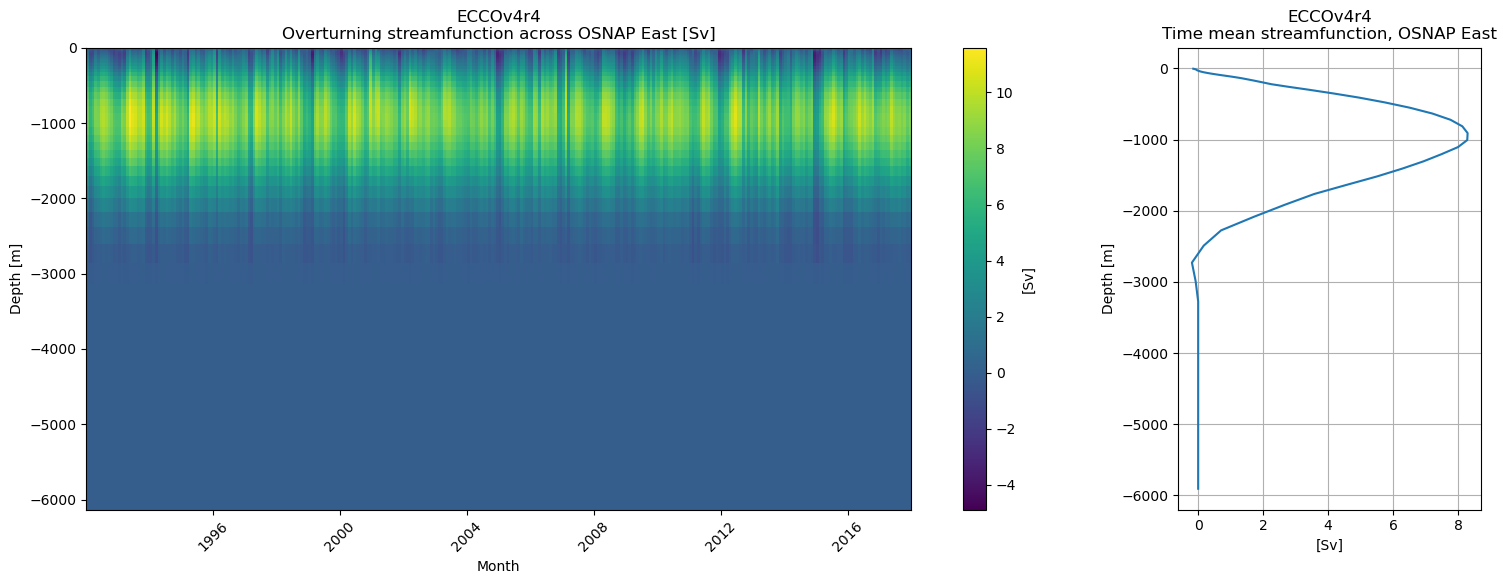

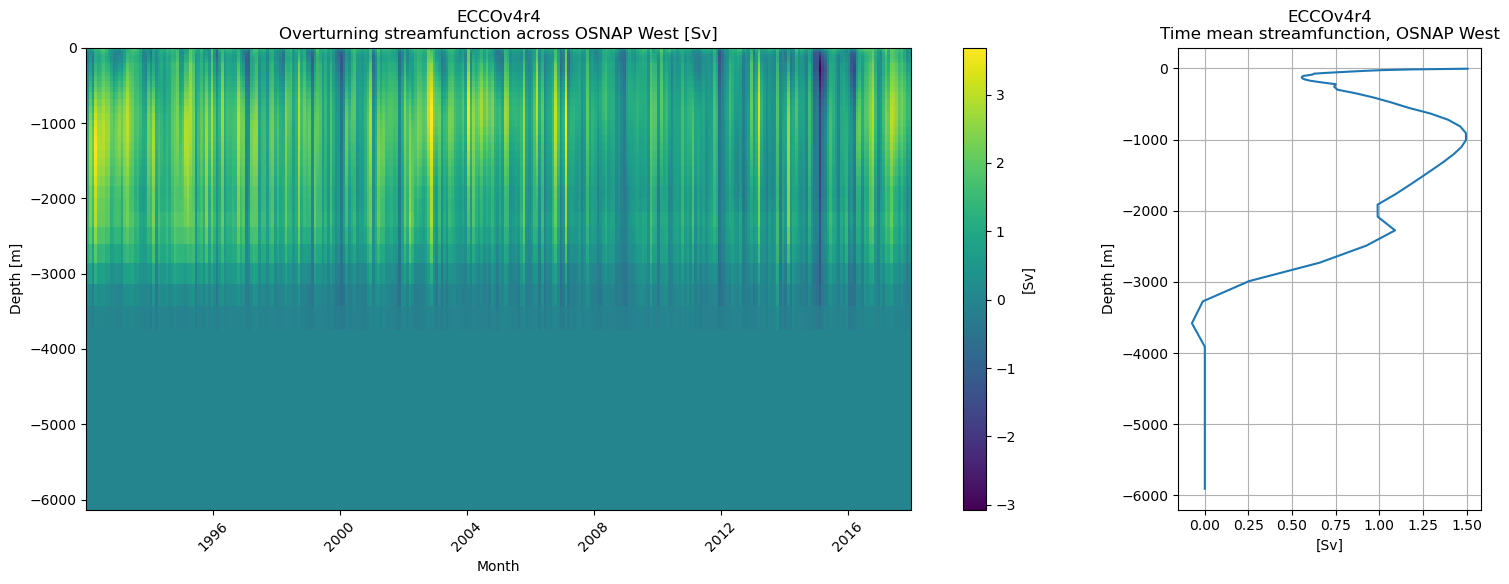

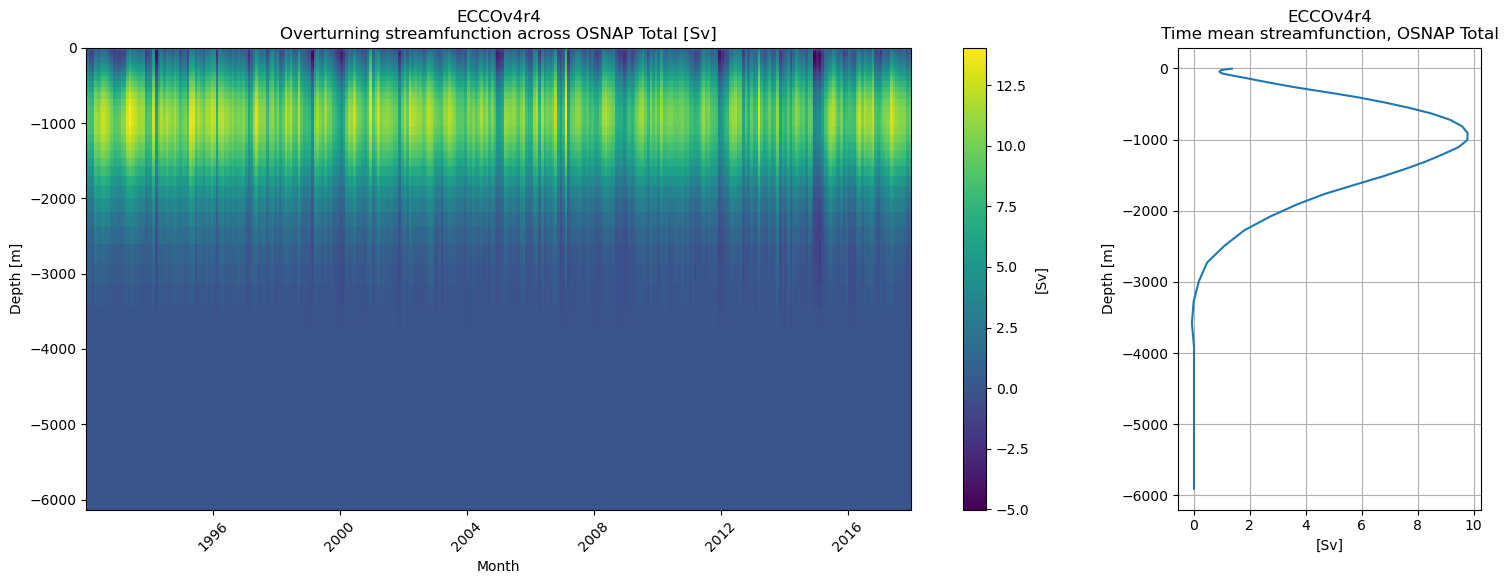

In [16]:
osnap_depth_stf_vs_time(osnap_z_stf_east,'East')
osnap_depth_stf_vs_time(osnap_z_stf_west,'West')
osnap_depth_stf_vs_time(osnap_z_stf_tot,'Total')

In [17]:
osnap_z_ov_east = osnap_z_stf_east['psi_moc'].max(dim='k')
osnap_z_ov_west = osnap_z_stf_west['psi_moc'].max(dim='k')
osnap_z_ov_tot = osnap_z_stf_tot['psi_moc'].max(dim='k')

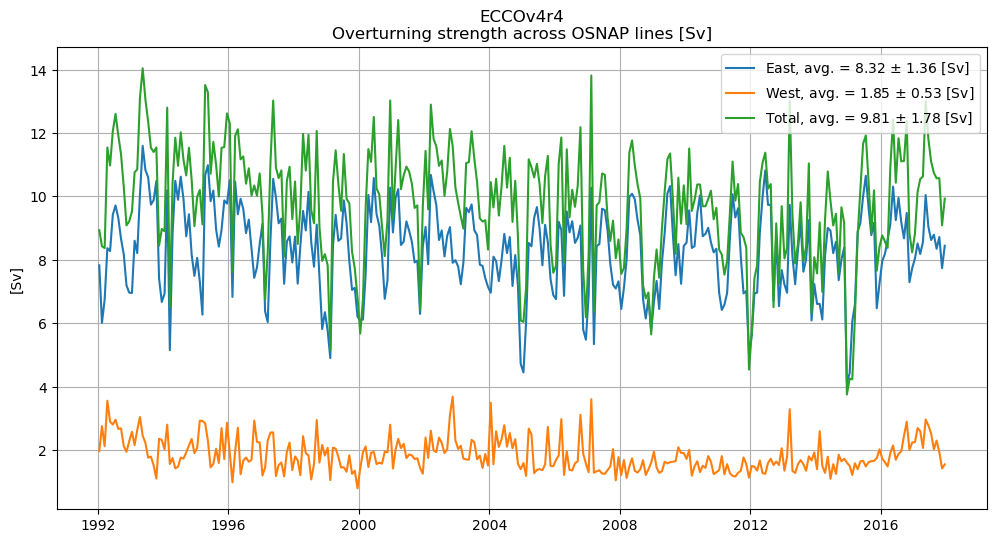

In [18]:
fig = plt.figure(figsize=(12,6))
plt.plot(osnap_z_ov_east['time'],osnap_z_ov_east)
plt.plot(osnap_z_ov_west['time'],osnap_z_ov_west)
plt.plot(osnap_z_ov_tot['time'],osnap_z_ov_tot)
plt.title('ECCOv4r4\nOverturning strength across OSNAP lines [Sv]')
plt.ylabel('[Sv]')
plt.legend((('East, avg. = %.2f $\pm$ %.2f [Sv]' % 
             (osnap_z_ov_east.mean('time').values,osnap_z_ov_east.std('time').values)),
            ('West, avg. = %.2f $\pm$ %.2f [Sv]' % 
             (osnap_z_ov_west.mean('time').values,osnap_z_ov_west.std('time').values)),
            ('Total, avg. = %.2f $\pm$ %.2f [Sv]' % 
             (osnap_z_ov_tot.mean('time').values,osnap_z_ov_tot.std('time').values))))
plt.grid()
plt.show()

## Compare to Observations

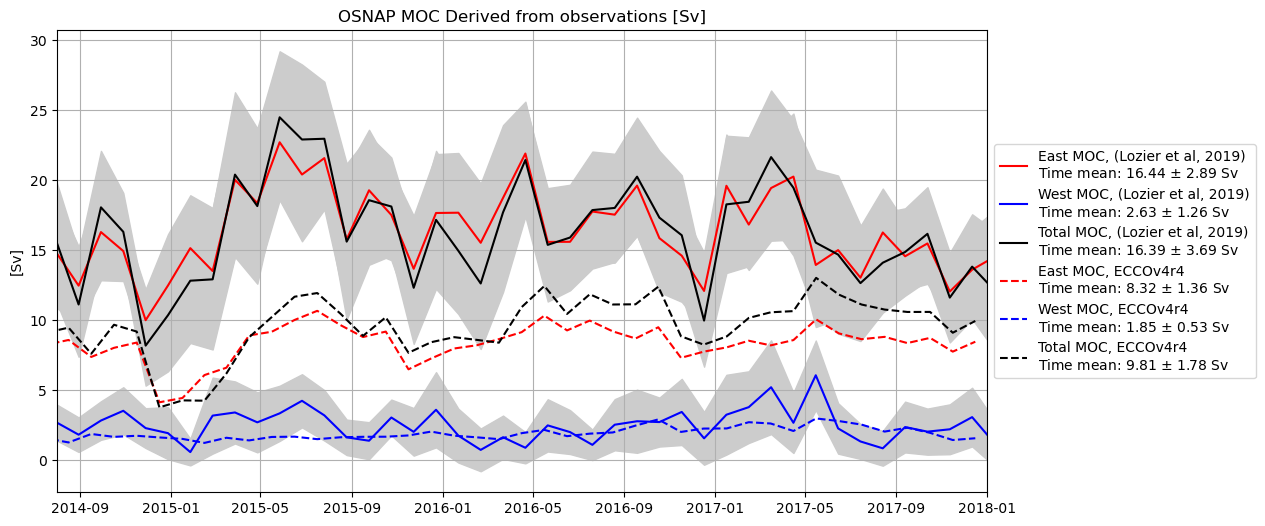

2023-05-02 21:25:35,339 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:49804', name: 2, status: running, memory: 0, processing: 0>
2023-05-02 21:25:35,379 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:49810', name: 3, status: running, memory: 0, processing: 0>
2023-05-02 21:25:35,389 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:49810'.
2023-05-02 21:25:35,398 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:49804'.
2023-05-02 21:25:39,424 - distributed.nanny - WARNING - Restarting worker
2023-05-02 21:25:39,459 - distributed.nanny - WARNING - Restarting worker
2023-05-03 19:30:38,689 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:49807', name: 0, status: running, me

In [19]:
plt.figure(figsize=(12,6))

var_list = ['MOC_EAST','MOC_WEST','MOC_ALL']
err_list = ['MOC_EAST_ERR','MOC_WEST_ERR','MOC_ALL_ERR']
obs_handles = []
for var, err in zip(var_list,err_list):
    if 'MOC_ALL' in var:
        clr = 'k'
    elif 'MOC_EAST' in var:
        clr = 'r'
    elif 'MOC_WEST' in var:
        clr = 'b'
    
        
    curr_hand = plt.plot(obs['TIME'],obs[var], color=clr)
    obs_handles.append(curr_hand[0])
    
    plt.fill_between(obs['TIME'].values,
                 obs[var]-obs[err],
                 obs[var]+obs[err],
                 color=[0.8,0.8,0.8])

# plot ECCO v4r4 equivalent
ecco_hand0 = plt.plot(osnap_z_ov_east['time'],osnap_z_ov_east, 'r--')
ecco_hand1 = plt.plot(osnap_z_ov_west['time'],osnap_z_ov_west, 'b--',)
ecco_hand2 = plt.plot(osnap_z_ov_tot['time'],osnap_z_ov_tot, 'k--')
ecco_handles = [ecco_hand0[0],ecco_hand1[0],ecco_hand2[0]]
plt.xlim(('2014-08','2018-01'))

plt.ylabel('[%s]' % obs['MOC_ALL'].units)
plt.grid()
plt.title('OSNAP MOC Derived from observations [%s]' % obs['MOC_ALL'].units)
plt.legend(handles=(obs_handles + ecco_handles),labels=(\
    ('East MOC, (Lozier et al, 2019)\nTime mean: %.2f $\pm$ %.2f %s' % 
            (obs['MOC_EAST'].mean('TIME'),obs['MOC_EAST'].std('TIME'),obs['MOC_EAST'].units)),
    ('West MOC, (Lozier et al, 2019)\nTime mean: %.2f $\pm$ %.2f %s' % 
            (obs['MOC_WEST'].mean('TIME'),obs['MOC_WEST'].std('TIME'),obs['MOC_WEST'].units)),
    ('Total MOC, (Lozier et al, 2019)\nTime mean: %.2f $\pm$ %.2f %s' % 
            (obs['MOC_ALL'].mean('TIME'),obs['MOC_ALL'].std('TIME'),obs['MOC_ALL'].units)),
    ('East MOC, ECCOv4r4\nTime mean: %.2f $\pm$ %.2f %s' % 
            (osnap_z_ov_east.mean('time'),osnap_z_ov_east.std('time'), \
             osnap_z_stf_east['psi_moc'].attrs['units'])),
    ('West MOC, ECCOv4r4\nTime mean: %.2f $\pm$ %.2f %s' % 
            (osnap_z_ov_west.mean('time'),osnap_z_ov_west.std('time'), \
             osnap_z_stf_west['psi_moc'].attrs['units'])),
    ('Total MOC, ECCOv4r4\nTime mean: %.2f $\pm$ %.2f %s' % 
            (osnap_z_ov_tot.mean('time'),osnap_z_ov_tot.std('time'), \
             osnap_z_stf_tot['psi_moc'].attrs['units']))),
    loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()